#Prediction Model for Distribution Center Receiving Forecast

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff
import sklearn.metrics as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM

In [202]:
import warnings 
warnings. filterwarnings("ignore")

In [203]:
! git clone https://github.com/aviraljoshi23/Hacks.git

fatal: destination path 'Hacks' already exists and is not an empty directory.


In [204]:
inbound = pd.read_excel('/content/Hacks/dataset-New/Inbound.xlsx')
sales = pd.read_excel('/content/Hacks/dataset-New/Sales units.xlsx')

In [205]:
units = pd.read_excel('/content/Hacks/dataset-New/Recipt Units.xlsx',parse_dates = False)

In [206]:
units.head()

,SCRUB_DC_NO,SCRUB_Category_no,Year,Week,ReceiptUnits
0,92,1,2019,1,22944.0
1,92,2,2019,1,32856.0
2,92,3,2019,1,1536.0
3,92,4,2019,1,55714.0
4,92,5,2019,1,940.0


In [207]:
units.tail()

,SCRUB_DC_NO,SCRUB_Category_no,Year,Week,ReceiptUnits
241492,64,186,2021,34,812.0
241493,64,187,2021,34,3372.0
241494,64,251,2021,34,25422.0
241495,64,188,2021,34,6231.0
241496,64,293,2021,34,347.0


In [208]:
unit_test = units.copy()

In [209]:
inbound.head()

,Scrub_dc_no,Year,Week,Inbound Truckloads
0,92,2019,1,115
1,76,2019,1,165
2,78,2019,1,161
3,98,2019,1,189
4,3,2019,1,113


In [210]:
sales.head()

,SCRUB_DC_NO,YEAR,WEEK,SCRUB_CATEGORY_NO,SALES_UNITS
0,3,2019,1,1,18871
1,3,2019,1,2,22076
2,3,2019,1,3,5459
3,3,2019,1,4,36976
4,3,2019,1,5,3832


In [211]:
def data_description(data):
  print(data.info())
  print('---'*30)
  print(data.describe().T)
  print('---'*30)
  print(data.isnull().any())
  print('---'*30)
  print(data.nunique())
  return 

In [212]:
data_description(units)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241497 entries, 0 to 241496
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SCRUB_DC_NO        241497 non-null  int64  
 1   SCRUB_Category_no  241497 non-null  int64  
 2   Year               241497 non-null  int64  
 3   Week               241497 non-null  int64  
 4   ReceiptUnits       241497 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 9.2 MB
None
------------------------------------------------------------------------------------------
                      count         mean          std  ...     50%     75%       max
SCRUB_DC_NO        241497.0    64.995346    28.327958  ...    76.0    92.0      98.0
SCRUB_Category_no  241497.0   140.843162    88.473886  ...   139.0   209.0     347.0
Year               241497.0  2019.901212     0.772693  ...  2020.0  2021.0    2021.0
Week               241497.0    24.371466    14.310415  ...   

In [213]:
data_description(inbound)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Scrub_dc_no         1093 non-null   int64
 1   Year                1093 non-null   int64
 2   Week                1093 non-null   int64
 3   Inbound Truckloads  1093 non-null   int64
dtypes: int64(4)
memory usage: 34.3 KB
None
------------------------------------------------------------------------------------------
                     count         mean        std  ...     50%     75%     max
Scrub_dc_no         1093.0    64.626715  28.617691  ...    76.0    92.0    98.0
Year                1093.0  2019.907594   0.781931  ...  2020.0  2021.0  2021.0
Week                1093.0    24.240622  14.299636  ...    24.0    35.0    52.0
Inbound Truckloads  1093.0   353.197621  89.245470  ...   355.0   416.0   638.0

[4 rows x 8 columns]
-------------------------------------------------------

In [214]:
data_description(sales)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356992 entries, 0 to 356991
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   SCRUB_DC_NO        356992 non-null  int64
 1   YEAR               356992 non-null  int64
 2   WEEK               356992 non-null  int64
 3   SCRUB_CATEGORY_NO  356992 non-null  int64
 4   SALES_UNITS        356992 non-null  int64
dtypes: int64(5)
memory usage: 13.6 MB
None
------------------------------------------------------------------------------------------
                      count         mean          std  ...     50%     75%       max
SCRUB_DC_NO        356992.0    64.501689    28.702662  ...    76.0    92.0      98.0
YEAR               356992.0  2019.873490     0.777990  ...  2020.0  2020.0    2021.0
WEEK               356992.0    24.371258    14.417331  ...    24.0    35.0      52.0
SCRUB_CATEGORY_NO  356992.0   165.169337    95.922414  ...   164.0   246.0     347.0
S

In [215]:
units.shape

(241497, 5)

In [216]:
units['SCRUB_DC_NO'].value_counts()

41    31723
92    31055
98    30647
78    30382
76    30026
65    29665
64    29198
3     28801
Name: SCRUB_DC_NO, dtype: int64

# Units Exploring 

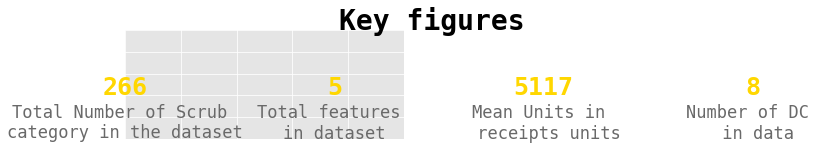

In [217]:
fig=plt.figure(figsize=(5,2),facecolor='white')

ax0=fig.add_subplot(1,1,1)
ax0.text(1.1,1,"Key figures",color='black',fontsize=28, fontweight='bold', fontfamily='monospace',ha='center')

ax0.text(0,0.4,"266",color='gold',fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0,0.005,"Total Number of Scrub \ncategory in the dataset",color='dimgrey',fontsize=17, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(0.75,0.4,"5",color='gold',fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0.75,0.001,"Total features \nin dataset",color='dimgrey',fontsize=17, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(1.5,0.4,"5117",color='gold',fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(1.5,0.001,"Mean Units in \n receipts units",color='dimgrey',fontsize=17, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(2.25,0.4,"8",color='gold',fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(2.25,0.001,"Number of DC \n in data",color='dimgrey',fontsize=17, fontweight='light', fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.tick_params(axis='y',length=0)
ax0.tick_params(axis='x',length=0)
ax0.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax0.spines[direction].set_visible(False)

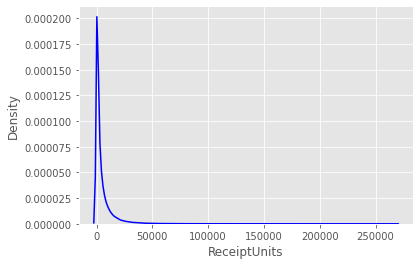

In [218]:
sns.kdeplot(units['ReceiptUnits'], color='b', shade=False, Label='ReceiptUnits') 

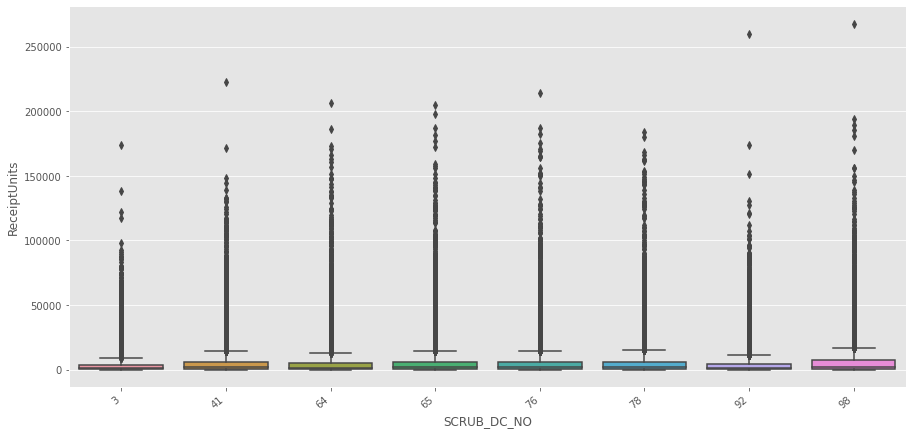

In [219]:
plt.subplots(figsize=(15,7))
ax=sns.boxplot(x='SCRUB_DC_NO',y='ReceiptUnits',data=units)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha='right')
plt.show()

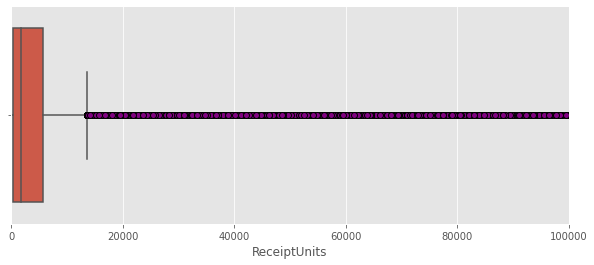

In [220]:
plt.figure(figsize=(10,4))
plt.xlim(-100,100000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=units.ReceiptUnits, flierprops=flierprops)

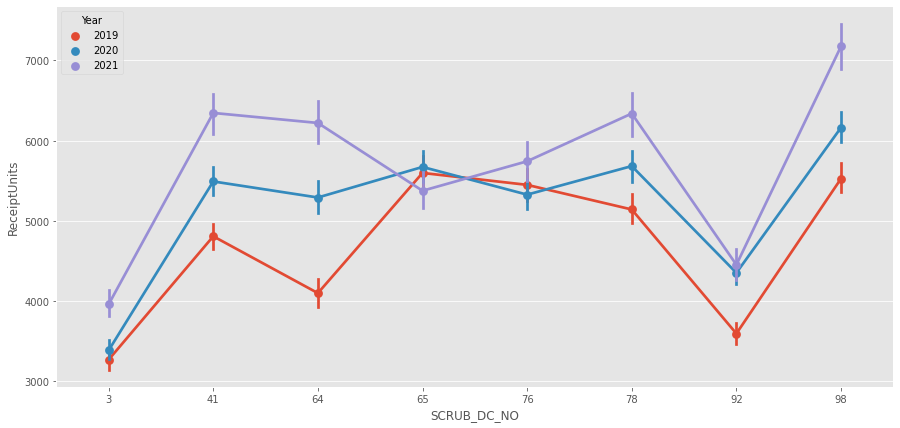

In [221]:
plt.figure(figsize=(15,7))
sns.pointplot(x='SCRUB_DC_NO', y='ReceiptUnits', hue='Year', data=units)
plt.show()

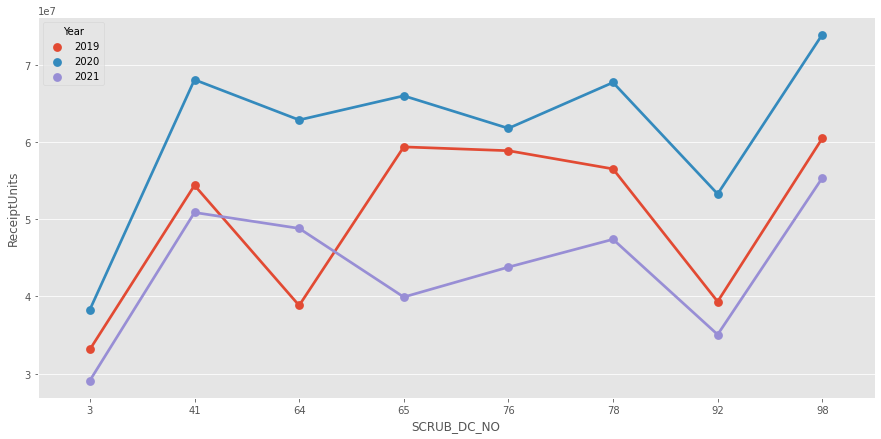

In [222]:
plt.figure(figsize=(15,7))
grouped = pd.DataFrame(units.groupby(['Year','SCRUB_DC_NO'])['ReceiptUnits'].sum().reset_index())
sns.pointplot(x='SCRUB_DC_NO', y='ReceiptUnits', hue='Year', data=grouped)
plt.show()

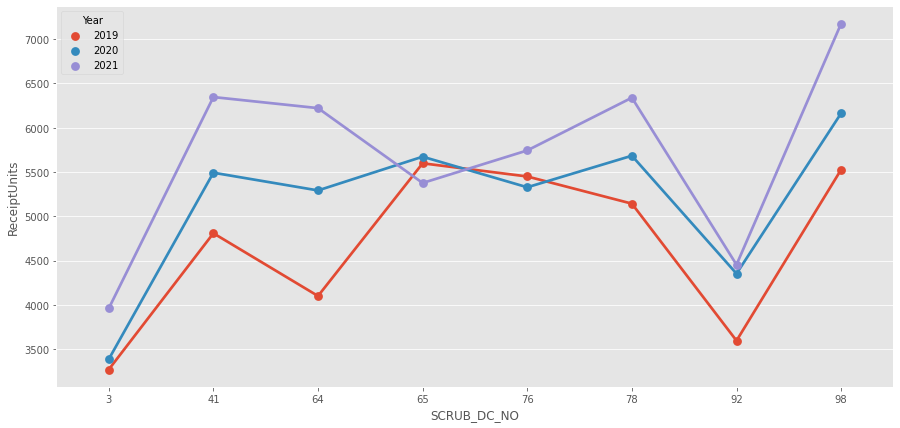

In [223]:
plt.figure(figsize=(15,7))
grouped = pd.DataFrame(units.groupby(['Year','SCRUB_DC_NO'])['ReceiptUnits'].mean().reset_index())
sns.pointplot(x='SCRUB_DC_NO', y='ReceiptUnits', hue='Year', data=grouped)
plt.show()

In [224]:
units['Week'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

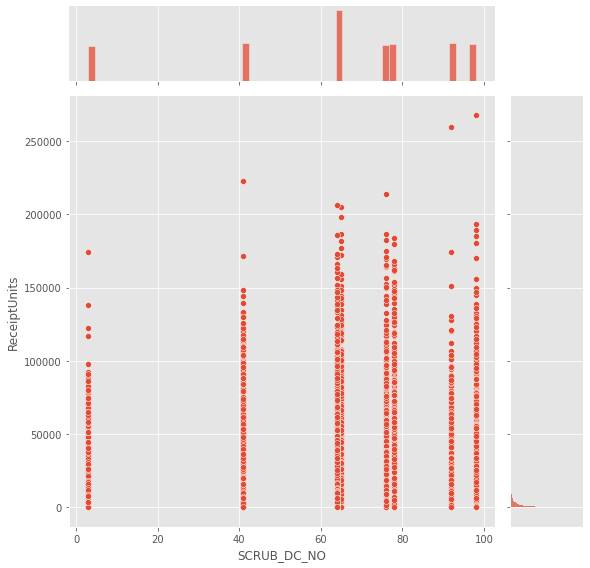

In [225]:
sns.jointplot(x="SCRUB_DC_NO", y="ReceiptUnits", data=units, height=8)
plt.show()

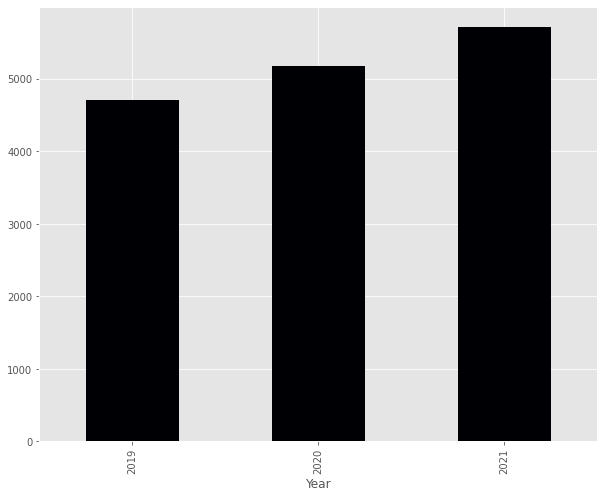

In [226]:
plt.figure(figsize=(10,8))
units.groupby('Year')['ReceiptUnits'].mean().plot(kind='bar',cmap = 'inferno')
plt.show()

***From the above figure we can see that units are increasing with the increase in the year***

In [227]:
units.sample()

,SCRUB_DC_NO,SCRUB_Category_no,Year,Week,ReceiptUnits
28570,92,16,2021,24,6522.0


#*Feature Engineering*

---



In [228]:
units.shape

(241497, 5)

In [229]:
# Dropping all rows whose 'ReceiptUnits' is negative 
l1 = np.where(units['ReceiptUnits'] < 0)
units.drop(l1[0],inplace=True)
units.index = range(0,units.shape[0])
units.shape

(241497, 5)

In [230]:
# Dropping all rows whose 'ReceiptUnits' is negative 
l2 = np.where(units['ReceiptUnits']<=50)
units.drop(l1[0],inplace=True)
units.index = range(0,units.shape[0])
units.shape

(241497, 5)

#*Correlation Plot*

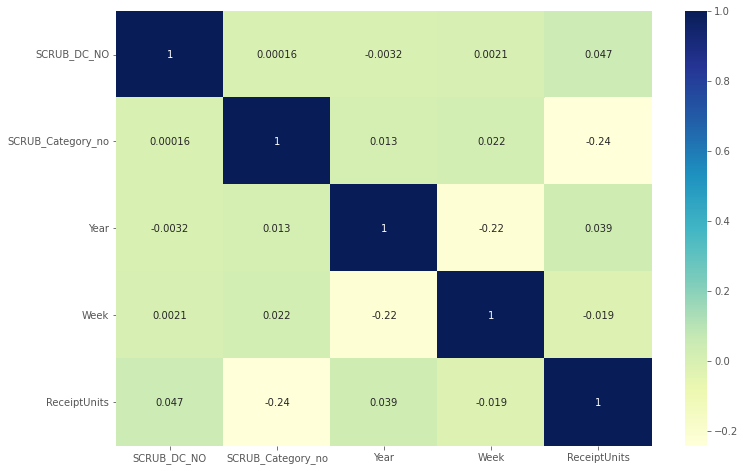

In [231]:
plt.figure(figsize=(12,8))
dataplot = sns.heatmap(units.corr(), cmap="YlGnBu", annot=True)
plt.show()

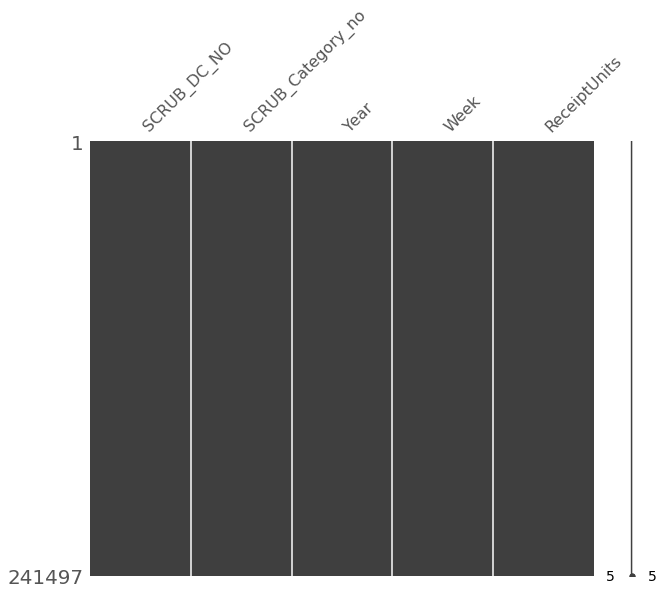

In [232]:
import missingno as msno
msno.matrix(units,figsize=(10,8))
plt.show()

In [233]:
print("Skewness: %f" % units['ReceiptUnits'].skew())

Skewness: 5.722103


In [234]:
units.sample()

,SCRUB_DC_NO,SCRUB_Category_no,Year,Week,ReceiptUnits
78790,78,246,2020,30,596.0


In [235]:
X = np.array(units.drop(['ReceiptUnits'],axis = 1))
y = np.array(units.iloc[:,4])

In [236]:
print(X.shape)
print(y.shape)

(241497, 4)
(241497,)


In [237]:
X

array([[  92,    1, 2019,    1],
       [  92,    2, 2019,    1],
       [  92,    3, 2019,    1],
       ...,
       [  64,  251, 2021,   34],
       [  64,  188, 2021,   34],
       [  64,  293, 2021,   34]])

In [238]:
y

array([22944., 32856.,  1536., ..., 25422.,  6231.,   347.])

In [239]:
#X = units.drop(['SCRUB_DC_NO','SCRUB_Category_no','Year','Week'], axis=1, inplace=True)
#y = units['ReceiptUnits']

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=43)

In [241]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(169047, 4)
(169047,)
(72450, 4)
(72450,)


In [242]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import time
import sys
import gc
import pickle

In [243]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

#make predictions using linear regression
y_predict =(linear_model.predict(X_test))

#Measure Performance 
linear_mse = mean_squared_error(y_test,y_predict)
print("Mean Squared error: ",linear_mse)
linear_SqMse = np.sqrt(linear_mse)
print("Root Mean Squared error: ", linear_SqMse)

print("Explain variance score for Linear Regression =", round(sm.explained_variance_score(y_test,y_predict),2)) 
print("R2 score for Linear Regression =", round(sm.r2_score(y_test, y_predict), 2))

Mean Squared error:  91711991.96289602
Root Mean Squared error:  9576.63782143274
Explain variance score for Linear Regression = 0.06
R2 score for Linear Regression = 0.06


In [244]:
# Create a model with 50 decision trees
forest_model= RandomForestRegressor(n_estimators = 50, random_state = 42)
forest_model.fit(X_train, y_train)

#make predictions using Random forest regresssor
y_predict2 =(forest_model.predict(X_test))

#Measure Performance 
forest_mse= mean_squared_error(y_test,y_predict2)
print("Mean Squared error: ",forest_mse)
forest_SqMse = np.sqrt(forest_mse)
print("Root Mean Squared error: ", forest_SqMse)

print("Explain variance score for Linear Regression =", round(sm.explained_variance_score(y_test,y_predict2),2)) 
print("R2 score for Linear Regression =", round(sm.r2_score(y_test, y_predict2), 2))

Mean Squared error:  58429576.92936055
Root Mean Squared error:  7643.924183909764
Explain variance score for Linear Regression = 0.4
R2 score for Linear Regression = 0.4


In [245]:
grad_boost = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100, random_state = 42)
grad_boost.fit(X_train, y_train)
#make predictions using Random forest regresssor
y_predict3 =(grad_boost.predict(X_test))

#Measure Performance 
grad_mse= mean_squared_error(y_test,y_predict3)
print("Mean Squared error: ",grad_mse)
grad_SqMse = np.sqrt(grad_mse)
print("Root Mean Squared error: ", grad_SqMse)

print("Explain variance score for Linear Regression =", round(sm.explained_variance_score(y_test,y_predict3),2)) 
print("R2 score for Linear Regression =", round(sm.r2_score(y_test, y_predict3), 2))


'''print('Train set mse:', mean_squared_error(y_train, grad_boost.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, grad_boost.predict(X_test)))
print('Train set score:', grad_boost.score(X_train,y_train))
print("Explain variance score for Linear Regression =", round(sm.explained_variance_score(y_test,y_predict2),2)) 
print("R2 score for Linear Regression =", round(sm.r2_score(y_test, y_predict2), 2))'''

Mean Squared error:  67706671.71360427
Root Mean Squared error:  8228.406389672564
Explain variance score for Linear Regression = 0.31
R2 score for Linear Regression = 0.31


'print(\'Train set mse:\', mean_squared_error(y_train, grad_boost.predict(X_train)))\nprint(\'Test set mse:\', mean_squared_error(y_test, grad_boost.predict(X_test)))\nprint(\'Train set score:\', grad_boost.score(X_train,y_train))\nprint("Explain variance score for Linear Regression =", round(sm.explained_variance_score(y_test,y_predict2),2)) \nprint("R2 score for Linear Regression =", round(sm.r2_score(y_test, y_predict2), 2))'

In [246]:
#SCRUB_DC_NO	SCRUB_Category_no	Year	Week	ReceiptUnits

SyntaxError: ignored

In [ ]:
#64	187	2021	34	

In [254]:
import lightgbm as lgb

In [247]:
xgb = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    min_child_weight=300,   
    colsample_bytree=0.8, 
    subsample=0.8, 
    gamma = 0.005,
    eta=0.1,    
    seed=42)

xgb.fit(X_train,y_train)

#make predictions using XGB Regresssor
y_predict4 =(xgb.predict(X_test))

#Measure Performance 
xgb_mse= mean_squared_error(y_test,y_predict4)
print("Mean Squared error: ",xgb_mse)
xgb_SqMse = np.sqrt(xgb_mse)
print("Root Mean Squared error: ", xgb_SqMse)

print("Explain variance score for Linear Regression =", round(sm.explained_variance_score(y_test,y_predict4),2)) 
print("R2 score for Linear Regression =", round(sm.r2_score(y_test, y_predict4), 2))


[09:36:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Squared error:  51150182.81002645
Root Mean Squared error:  7151.935598845004
Explain variance score for Linear Regression = 0.48
R2 score for Linear Regression = 0.48


In [255]:
# lgb hyper-parameters
%time
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}


# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dtest = lgb.Dataset(X_test, y_test)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dtest),
                      early_stopping_rounds=150,
                      verbose_eval=100)   

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Training until validation scores don't improve for 150 rounds.
[100]	training's rmse: 8756	valid_1's rmse: 8747.99
[200]	training's rmse: 8018.55	valid_1's rmse: 8073.74
[300]	training's rmse: 7614.9	valid_1's rmse: 7723.04
[400]	training's rmse: 7376.22	valid_1's rmse: 7532.4
[500]	training's rmse: 7216.84	valid_1's rmse: 7418.27
[600]	training's rmse: 7115.95	valid_1's rmse: 7354.83
[700]	training's rmse: 7044.62	valid_1's rmse: 7315.96
[800]	training's rmse: 6985.97	valid_1's rmse: 7287.62
[900]	training's rmse: 6940.38	valid_1's rmse: 7265.94
[1000]	training's rmse: 6901.65	valid_1's rmse: 7249.45
[1100]	training's rmse: 6868.9	valid_1's rmse: 7235.8
[1200]	training's rmse: 6837.5	valid_1's rmse: 7226.55
[1300]	training's rmse: 6809.89	valid_1's rmse: 7218.1
[1400]	training's rmse: 6786.64	valid_1's rmse: 7210.61
[1500]	training's rmse: 6763.94	valid_1's rmse: 7205.35
Did not meet early stopping. Best iteration is:
[150

In [ ]:
64	186	2021	34	

In [257]:
SCRUB_DC_NO = 64
SCRUB_Category_no = 186
Year = 2021
Week = 34
#3372.0
prediction=lgb_model.predict([[SCRUB_DC_NO,SCRUB_Category_no,Year,Week]])
print('Receipt Unit {}'.format(prediction))

Receipt Unit [1329.74177425]


In [263]:
pickle.dump(lgb_model, open('Light_bgm_model.pkl','wb'))

In [258]:
test_data = pd.read_csv('/content/final_dummy_ReceiptUnits.csv')
test_data.head()

,SCRUB_DC_NO,SCRUB_Category_no,Year,Week
0,76,75,2021,35
1,76,318,2021,35
2,76,240,2021,35
3,76,304,2021,35
4,76,19,2021,35


In [264]:
test_copy = test_data.copy()

In [ ]:
#pickle.dump(regressor, open('model.pkl','wb'))

In [265]:
prediction = lgb_model.predict(test_data)

In [267]:
sub_df = pd.DataFrame({'SCRUB_DC_NO':test_copy.SCRUB_DC_NO,
                       'SCRUB_Category_no':test_copy.SCRUB_Category_no,
                       'Year':test_copy.Year,
                       'Week':test_copy.Week,
                       'ReceiptUnits': prediction})

In [268]:
sub_df.to_csv('prediction.csv', index=False)